In [ ]:
%matplotlib inline

#Enable reloading because restarting the kernel is a pain
%load_ext autoreload
%autoreload 2

import shapely
from shapely.geometry import Polygon, Point

import matplotlib.pyplot as plt
import numpy as np

from bot_2d_rep import *
from bot_2d_problem import *

import copy

from jupyter_dash import JupyterDash
from dash import html, dcc, Input, Output
import plotly.graph_objects as go
import pandas as pd

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Set up & run the simple MOO problem

In [13]:
sensor_bounds = Polygon([(.1,.1), (-.1,.1),(-.1,-.2),(.1,-.2)])

sensor_options = [FOV2D_Simple(hfov=90, distance=12, cost=80.00, color="purple", bounds_polygon=copy.deepcopy(sensor_bounds)),
                  FOV2D_Simple(hfov=270, distance=10, cost=200.00, color="green", bounds_polygon=copy.deepcopy(sensor_bounds)),
                  FOV2D_Simple(hfov=60, distance=20, cost=150.00, color="orange", bounds_polygon=copy.deepcopy(sensor_bounds)),
                  FOV2D_Simple(hfov=75, distance=9, cost=30.00, color="pink", bounds_polygon=copy.deepcopy(sensor_bounds))]

bot_diam = 1
bot_bounds = Polygon([(-1, -2), (-1, 2), (1, 2), (1, -2)])
sens_constraint = Polygon(Point(0, 0).buffer(bot_diam+.1).exterior.buffer(0.2))
sense_requirement =  Polygon(Point(0, 0).buffer(12).exterior.coords)
sense_requirement = shapely.affinity.scale(sense_requirement, xfact=2/3, yfact=1, origin=(0, 0))
sense_requirement = shapely.affinity.translate(sense_requirement, xoff=0, yoff=4)

bot = SimpleBot2d(bot_bounds, sense_requirement, sensor_pose_constraint=sens_constraint)

In [14]:
from pymoo.algorithms.moo.nsga2 import NSGA2, RankAndCrowdingSurvival
from pymoo.core.mixed import MixedVariableGA
from pymoo.optimize import minimize
from pymoo.visualization.scatter import Scatter
from pymoo.operators.crossover.sbx import SBX
from pymoo.operators.mutation.pm import PM
from pymoo.operators.sampling.rnd import FloatRandomSampling

problem = SensorPkgOptimization(bot, sensor_options, 5)

algorithm = MixedVariableGA(
    pop_size=300,
    n_offsprings=120,
    sampling=CustomSensorPkgRandomSampling(),
    survival=RankAndCrowdingSurvival(),
    eliminate_duplicates=False
)

n_gen  |  n_eval  |     f_avg     |     f_min    
     1 |      300 |  0.3569871668 |  0.1925181876
     2 |      420 |  0.3538403989 |  0.1925181876
     3 |      540 |  0.3553906066 |  0.1925181876
     4 |      660 |  0.3586454117 |  0.1925181876
     5 |      780 |  0.3580887053 |  0.1925181876
     6 |      900 |  0.3586852523 |  0.1925181876
     7 |     1020 |  0.3648525613 |  0.1925181876
     8 |     1140 |  0.3634893300 |  0.1925181876
     9 |     1260 |  0.3623016826 |  0.1925181876
    10 |     1380 |  0.3642586377 |  0.1925181876
    11 |     1500 |  0.3592874496 |  0.1925181876
    12 |     1620 |  0.3565670378 |  0.1925181876
    13 |     1740 |  0.3467267199 |  0.0903651857
    14 |     1860 |  0.3426917802 |  0.0903651857
    15 |     1980 |  0.3380639938 |  0.0903651857
    16 |     2100 |  0.3289788824 |  0.0903651857
    17 |     2220 |  0.3261554701 |  0.0903651857
    18 |     2340 |  0.3251278948 |  0.0903651857
    19 |     2460 |  0.3250925097 |  0.0903651857


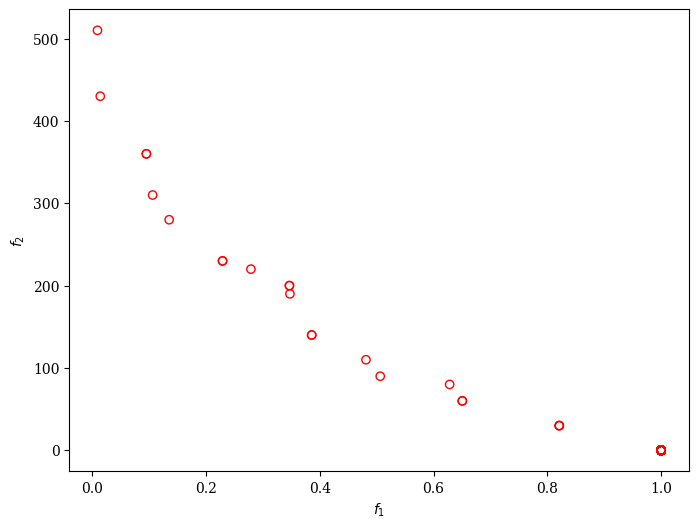

In [15]:
res = minimize(problem,
               algorithm,
               ('n_gen', 1000),
               seed=1,
               verbose=True)

pareto_front = problem.pareto_front(use_cache=False, flatten=False)
plot = Scatter()
plot.add(pareto_front, plot_type="line", color="black", alpha=0.7)
plot.add(res.F, facecolor="none", edgecolor="red")
plot.show()

In [29]:
import pandas as pd

import plotly.express as px

results = res.F

# Create a DataFrame from the results
df_results = pd.DataFrame(results, columns=['Perception Coverage', 'Cost'])
df_results['Perception Coverage'] = (1- df_results['Perception Coverage']) * 100
df_results['Index'] = df_results.index

# Create the scatter plot
fig = px.scatter(df_results, x='Cost', y='Perception Coverage', hover_data=['Index'], title=f"Objective Space (generated {results.shape[0]} concepts)", template="plotly_white")

# Show the plot
fig.show()


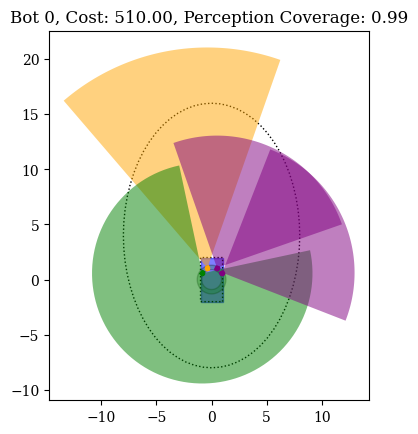

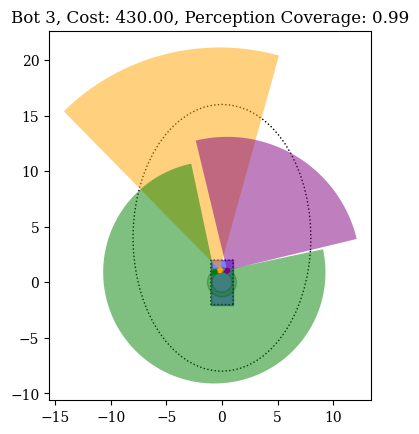

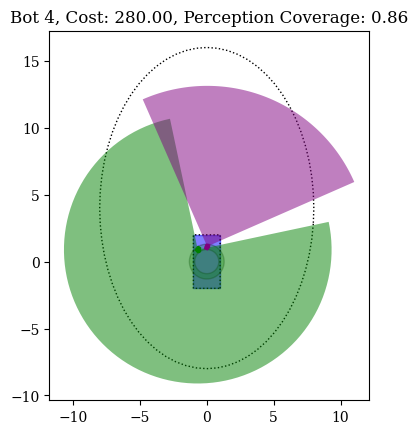

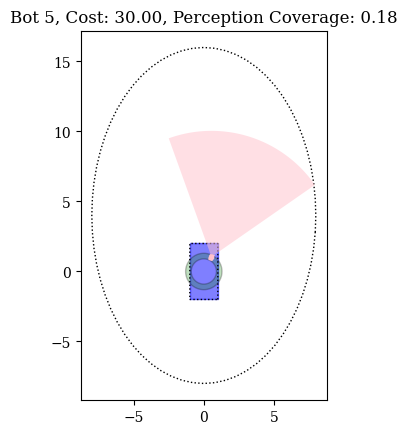

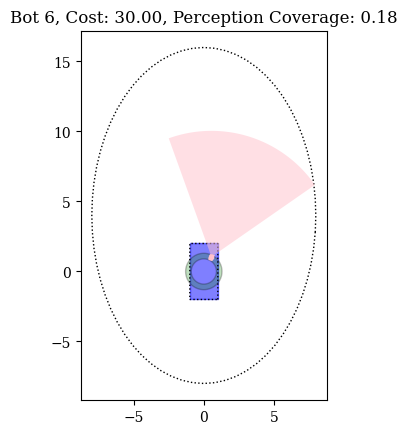

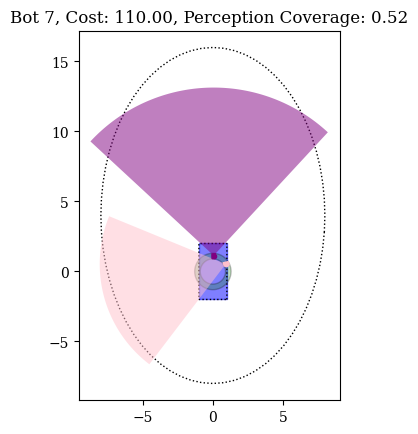

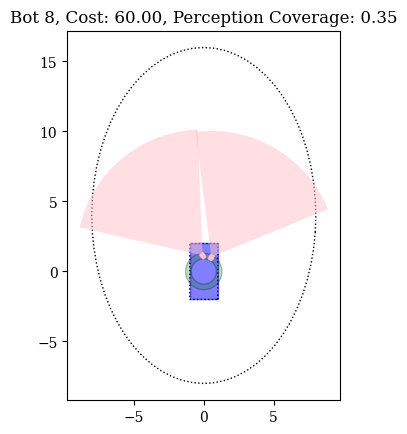

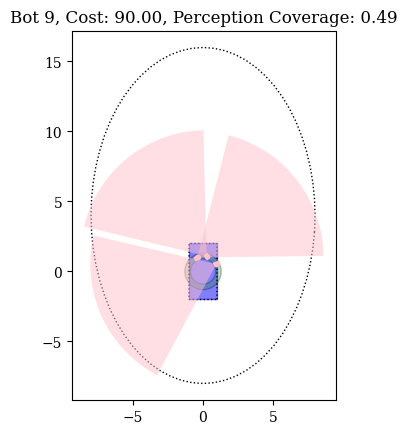

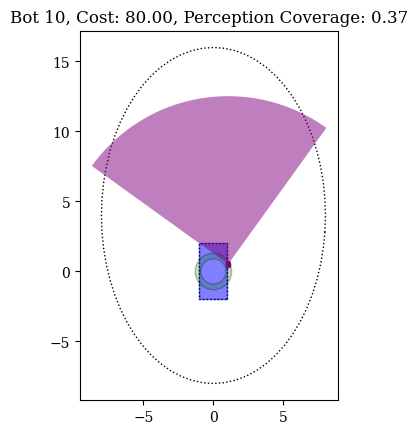

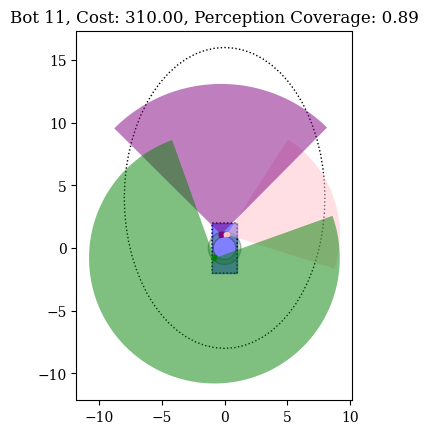

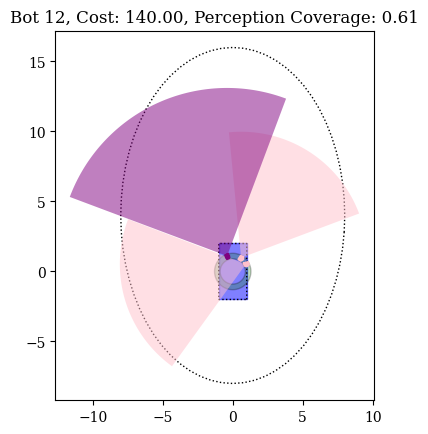

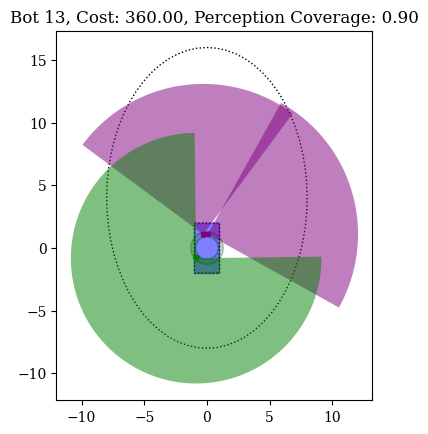

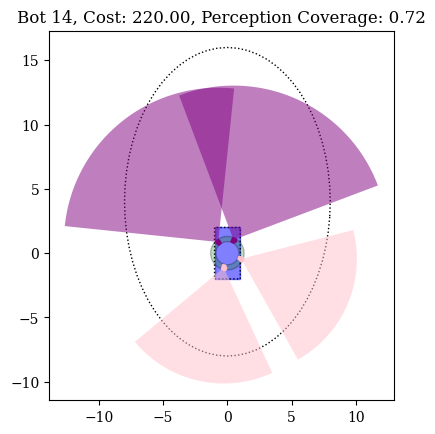

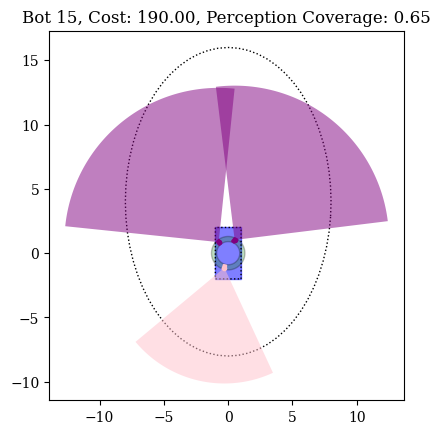

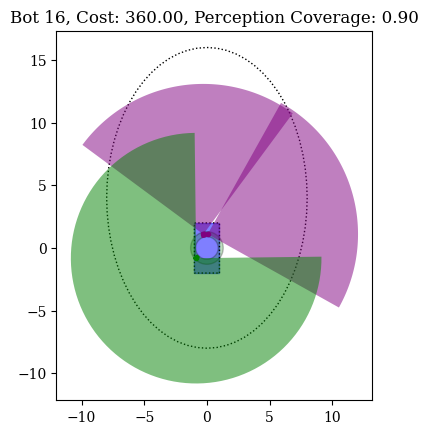

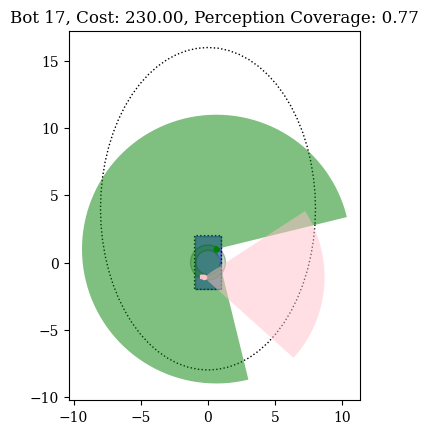

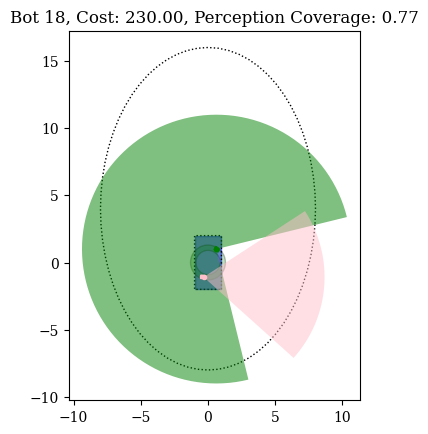

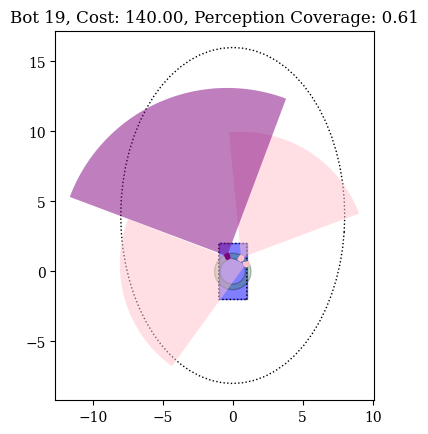

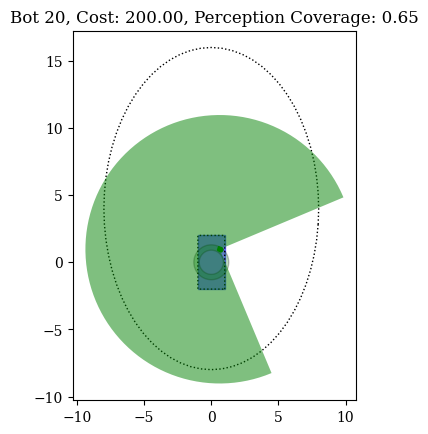

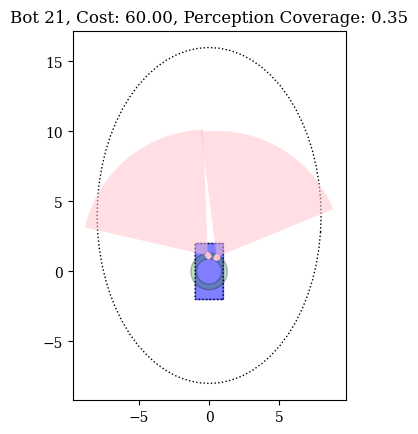

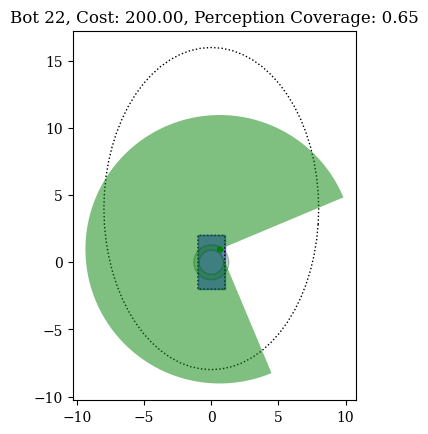

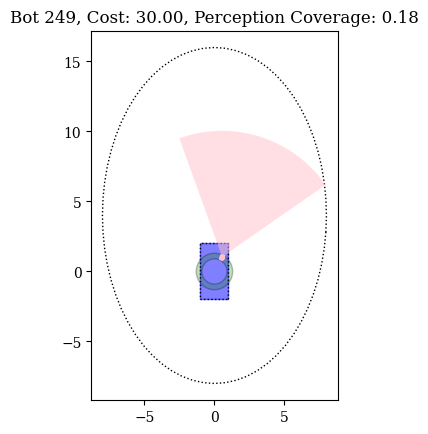

In [28]:
pareto_front_indices = np.where(res.F[:, 0] < 1)[0]  # Assuming the first objective is the perception coverage

for idx in pareto_front_indices:
    problem.convert_1D_to_bot(res.X[idx]).plot_bot(show_constraint=True, 
                                                   title=f"Bot {idx}, Cost: {res.F[idx, 1]:.2f}, Perception Coverage: {1-res.F[idx, 0]:.2f}")